# Installation

Followed the instructions in [#1], there are a few things to be careful about:

1) download the CUDA SDK [from Nvidia](https://developer.nvidia.com/cuda-downloads);

2) just installing the given `.deb` only adds the PPA; you **must** run the `apt-get install cuda` step;

3) it takes *a long time* to get the installation done, just be patient;

4) **pay attention** to the packages for `cuDNN`: these are the ones that eventually worked for CUDA 8.0:

    libcudnn6_6.0.21-1+cuda8.0_amd64.deb      
    libcudnn6-dev_6.0.21-1+cuda8.0_amd64.deb
    libcudnn6-doc_6.0.21-1+cuda8.0_amd64.deb

   downloaded [from here](https://developer.nvidia.com/rdp/cudnn-download) - make sure to choose 
   **Download cuDNN v6.0 (April 27, 2017), for CUDA 8.0** (or whatever is the version of CUDA you
   installed in step #1)


[1.] [Fundamentals of Deep Learning](https://www.safaribooksonline.com/library/view/fundamentals-of-deep/9781491925607/ch03.html), O'Reilly

# Logistic regression example

In [9]:
import os
from utils import input_data
import tensorflow as tf

datadir = os.path.join("/data/store/code", "deeplearning", "data")
logdir = os.path.join("/data/store/code", "deeplearning", "logs")
checkpoint = os.path.join(logdir, "model-checkpoint")


In [2]:
def inference(x):
    init = tf.constant_initializer(value=0)
    W = tf.get_variable("W", [784, 10],
                         initializer=init)
    b = tf.get_variable("b", [10],
                         initializer=init)
    output = tf.nn.softmax(tf.matmul(x, W) + b)
    return output

In [3]:
def loss(output, y):
    dot_product = y * tf.log(output)

    # Reduction along axis 0 collapses each column into a
    # single value, whereas reduction along axis 1 collapses  
    # each row into a single value. In general, reduction along  
    # axis i collapses the ith dimension of a tensor to size 1.
    xentropy = -tf.reduce_sum(dot_product, reduction_indices=1)
    
    return tf.reduce_mean(xentropy)

In [4]:
def training(cost, global_step, learning_rate=0.1):
    tf.summary.scalar("cost", cost)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(cost, global_step=global_step)
    
    return train_op

In [5]:
def evaluate(output, y):
    correct_prediction = tf.equal(tf.argmax(output, 1), 
                                  tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 
                                      tf.float32))
    return accuracy

In [6]:
def rel_accuracy_improv(prev, curr):
    if prev == 0:
        return 0
    return abs(curr - prev) / prev

In [8]:
# Load the MNIST data set
mnist = input_data.read_data_sets(datadir, one_hot=True)

# Parameters
learning_rate = 0.01
training_epochs = 1000
batch_size = 100
display_step = 5
prev_accuracy = 0.001
relative_accuracy_threshold = 0.001

with tf.Graph().as_default():
    
    # mnist data image of shape 28*28=784
    x = tf.placeholder("float", [None, 784])

    # 0-9 digits recognition => 10 classes
    y = tf.placeholder("float", [None, 10])

    output = inference(x)
    cost = loss(output, y)

    global_step = tf.Variable(0, name='global_step', trainable=False)

    train_op = training(cost, global_step)
    eval_op = evaluate(output, y)
    summary_op = tf.summary.merge_all()

    saver = tf.train.Saver()
    sess = tf.Session()

    summary_writer = tf.summary.FileWriter(logdir, graph=sess.graph)
    init_op = tf.global_variables_initializer()
    
    sess.run(init_op)

    # Training cycle
    for epoch in range(training_epochs):

        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            mbatch_x, mbatch_y = mnist.train.next_batch(batch_size)
            
            # Fit training using batch data
            feed_dict = {
                x : mbatch_x, 
                y : mbatch_y
            }
            sess.run(train_op, feed_dict=feed_dict)
            
            # Compute average loss
            minibatch_cost = sess.run(cost, feed_dict=feed_dict)
            avg_cost += minibatch_cost/total_batch
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost =", "{:.9f}".format(avg_cost))

            val_feed_dict = {
                 x : mnist.validation.images, 
                 y : mnist.validation.labels
            }
            accuracy = sess.run(eval_op, feed_dict=val_feed_dict)

            summary_str = sess.run(summary_op, feed_dict=feed_dict)
            summary_writer.add_summary(summary_str, sess.run(global_step))

            saver.save(sess, checkpoint, global_step=global_step)

            print("Validation Error:", (1 - accuracy))           
            if rel_accuracy_improv(curr=accuracy, prev=prev_accuracy) < relative_accuracy_threshold:
                break
            prev_accuracy = accuracy
            

    print("Optimization Finished!")
 
    test_feed_dict = {
         x : mnist.test.images,
         y : mnist.test.labels
    }b
    accuracy = sess.run(eval_op, feed_dict=test_feed_dict)
    print ("Test Accuracy:", accuracy)

Extracting /data/store/code/deeplearning/data/train-images-idx3-ubyte.gz
Extracting /data/store/code/deeplearning/data/train-labels-idx1-ubyte.gz
Extracting /data/store/code/deeplearning/data/t10k-images-idx3-ubyte.gz
Extracting /data/store/code/deeplearning/data/t10k-labels-idx1-ubyte.gz
Epoch: 0001 cost = 0.521184075
Validation Error: 0.100600004196
Epoch: 0006 cost = 0.292908132
Validation Error: 0.0767999887466
Epoch: 0011 cost = 0.274613709
Validation Error: 0.074599981308
Epoch: 0016 cost = 0.265203211
Validation Error: 0.0735999941826
Epoch: 0021 cost = 0.259620939
Validation Error: 0.0741999745369
Optimization Finished!
Test Accuracy: 0.9238


In [ ]:
import matplotlib
import warnings

matplotlib.use('TkAgg')
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import random

In [13]:
step_range = 10
step_choices = range(-1 * step_range, step_range + 1)
rand_walk = [random.choice(step_choices) for x in range(100)]

In [24]:
momentum = 0.8
momentum_walk = [random.choice(step_choices)]
for i in range(1, len(rand_walk)):
    prev = momentum_walk[i -1]
    rand_choice = random.choice(step_choices)
    new_step = momentum * prev + (1 - momentum) * rand_choice
    momentum_walk.append(new_step)

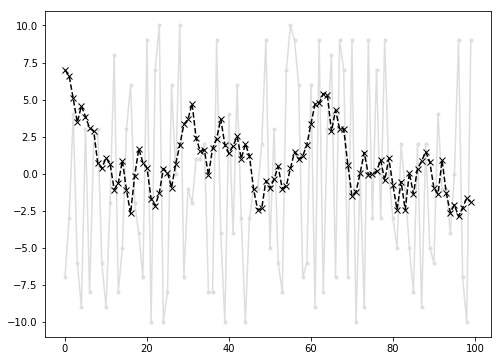

In [28]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)
#ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(rand_walk, color='#DEDEDE', marker='.')
ax1.plot(momentum_walk, linestyle='--', color='k', marker='x')
plt.show()

# RMSProp Optimizer

To use the RMSProp optimizer, where we "decay" the accumulation factor.
This scales the learning factor at each step, so that "slow moving"
parameters have larger learning rates than faster moving ones.

```
optimizer = tf.train.RMSPropOptimizer(learning_rate,
                                      decay=0.9,
                                      momentum=0.0, 
                                      epsilon=1e-10,
                                      use_locking=False, 
                                      name='RMSProp')
```


# Adam optimizer

Combines momentum (first moment) with RMSProp (second moment) of the gradient, adjusting for bias (the initialization of the correction factors).

In TensorFlow we can use:

```
tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, 
                       beta2=0.999, epsilon=1e-08, 
                       use_locking=False, name='Adam')
```

See: Kingma, Diederik, and Jimmy Ba. “[Adam: A Method for Stochastic Optimization.](https://arxiv.org/abs/1412.6980)” (2014).